In [1]:
import numpy as np
from collections import OrderedDict

%matplotlib notebook
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sys import path as syspath
syspath.append("./functions/")

from physio_def_1 import *

In [2]:
import scipy.signal as signal

In [3]:
%%time
#much fast if previously downloaded
allData = np.load('/Volumes/physio/team/slakrupnik/project/Python/Experiment38c_Series009.npy')

CPU times: user 6.31 ms, sys: 3.25 s, total: 3.25 s
Wall time: 3min 15s


In [41]:
## need to know frequency, or estimate
frequency = 10
time = np.arange(len(allData))/frequency

In [9]:
roiWidth = 4
NRois = 100

In [10]:
# to get repeatable Rois:
np.random.seed(0)

In [11]:
RoiOrigins = np.array([
    np.random.randint(allData.shape[1]-roiWidth,size=NRois),
    np.random.randint(allData.shape[2]-roiWidth,size=NRois)
]).T

<IPython.core.display.Javascript object>


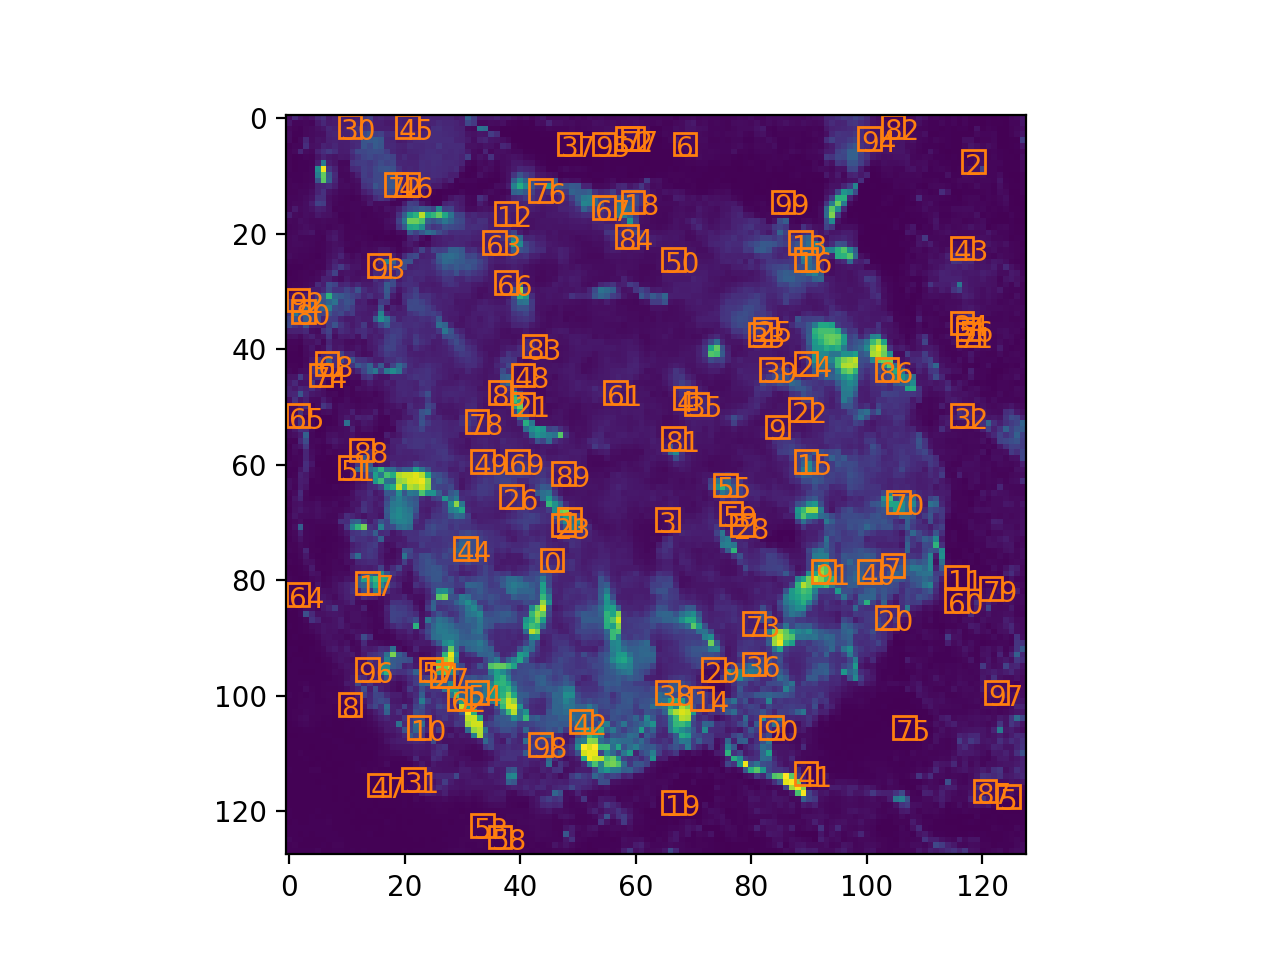

In [12]:
plt.figure()
ax = plt.subplot(111)
plt.imshow(allData[:100].mean(0))
addRoisToImage(RoiOrigins,roiWidth,ax=ax,label=True)

<IPython.core.display.Javascript object>


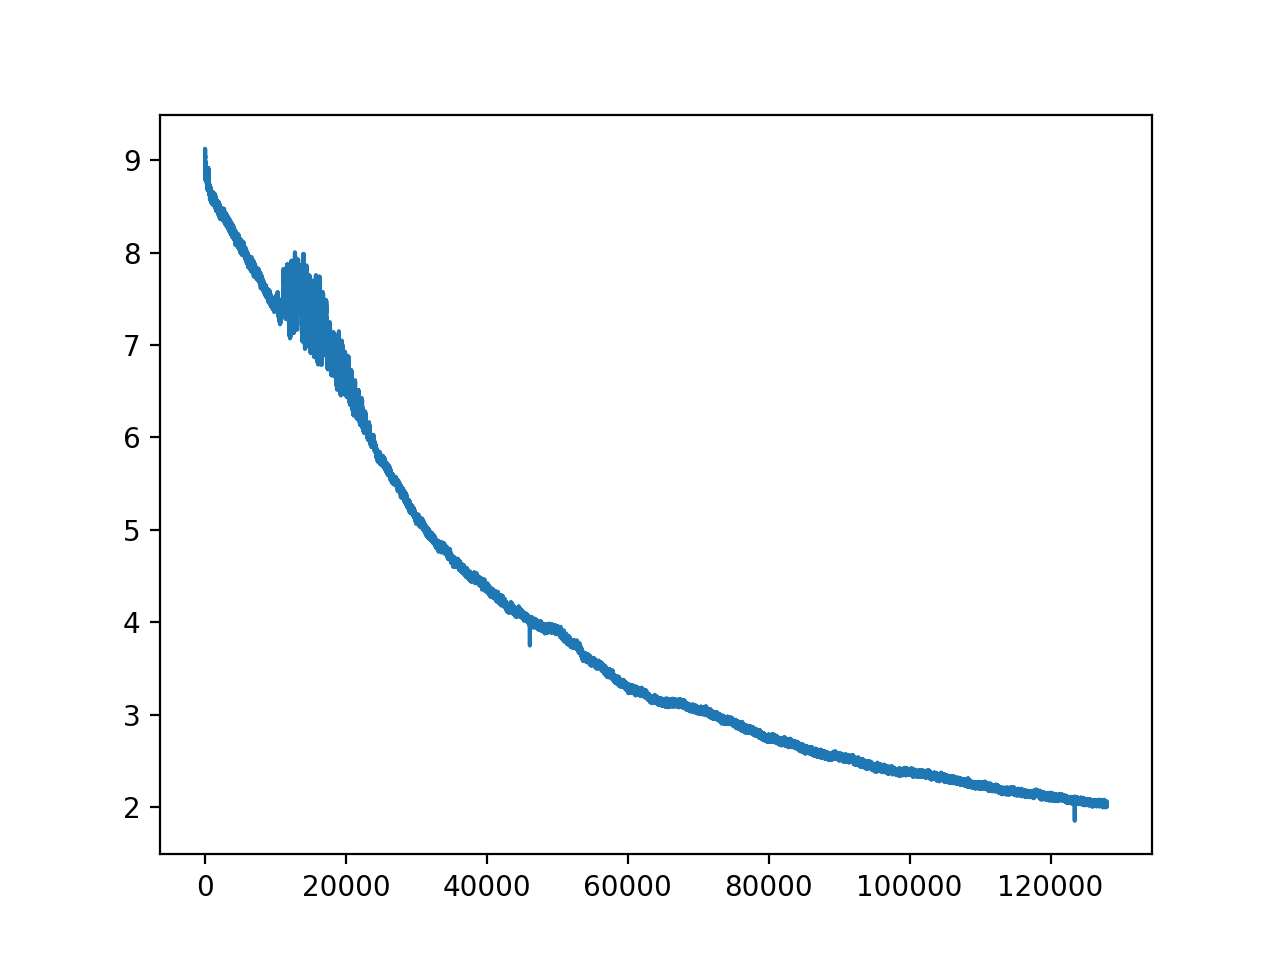

In [13]:
plt.figure()
ax = plt.subplot(111)
plt.plot(allData.mean((1,2)))

In [14]:
roiProfiles = getRoiProfiles(RoiOrigins,roiWidth,image_=allData)

In [61]:
ts = np.vstack(list(roiProfiles.values()))

In [62]:
pos = RoiOrigins+roiWidth/2
ncells = len(ts)

In [63]:
x = ts[0]

In [64]:
tWin = 10

<IPython.core.display.Javascript object>


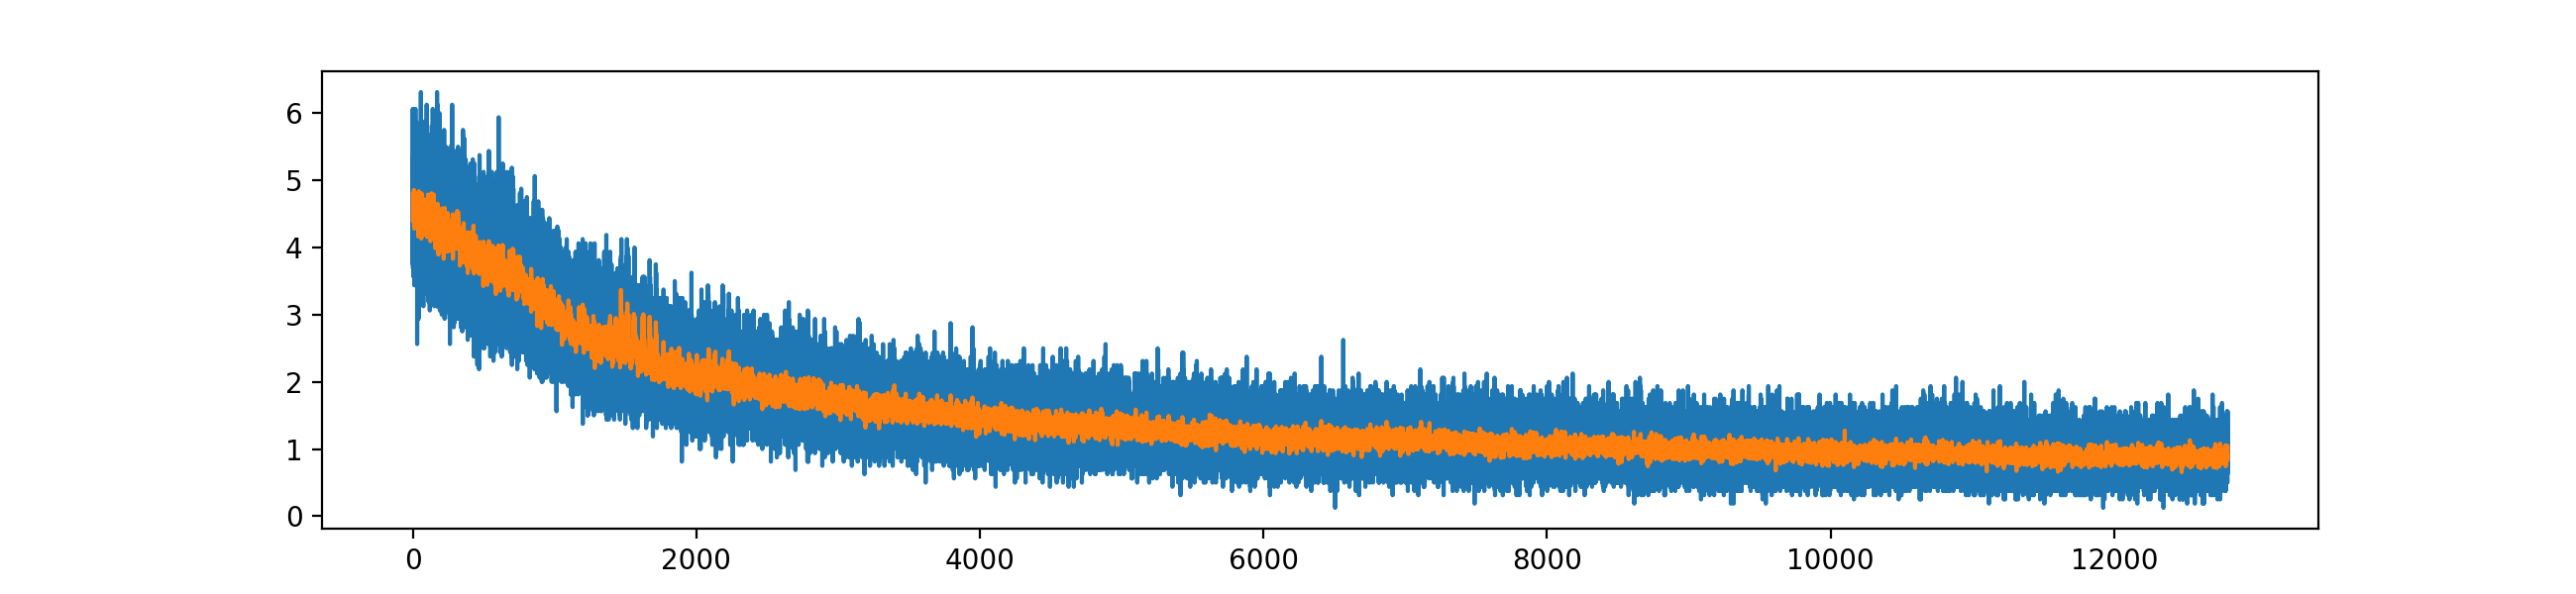

In [65]:
plt.figure(figsize=(13,3))
plt.plot(time,x)
plt.plot(rebin(time,tWin),rebin(x, tWin))

In [66]:
# So, we can reduce the number of points to save time
ts = rebin(ts,tWin, axis=1)

In [226]:
np.nanpercentile([1,2,1,np.nan],2)

1.0

In [227]:
from numba import jit,float32,int32,int32
@jit((float32[:],float32,int32))
def percFilter(x_,perc,filterSize):
#     if filterSize%2==0:
#         raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanpercentile(x_[i:i+filterSize],perc)
    return out

<ipython-input-227-dbf7dc954dc2>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "percFilter" failed type inference due to: Type of variable 'x_.1' cannot be determined, operation: $0.24, location: <ipython-input-227-dbf7dc954dc2> (8)

File "<ipython-input-227-dbf7dc954dc2>", line 8:
def percFilter(x_,perc,filterSize):
    <source elided>
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
    ^

  @jit((float32[:],float32,int32))
<ipython-input-227-dbf7dc954dc2>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "percFilter" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-227-dbf7dc954dc2>", line 10:
def percFilter(x_,perc,filterSize):
    <source elided>
#     print (x_.shape, out.shape)
    for i in range(len(out)):
    ^

  @jit((float32[:],float32,int32))
/Users/srdjan/an

In [195]:
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be add number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out

In [169]:
# %%timeit
percFilter(x[:],1,101)

array([-0.10625, -0.10625, -0.10625, ..., -0.0375 , -0.0375 , -0.0375 ])

<IPython.core.display.Javascript object>


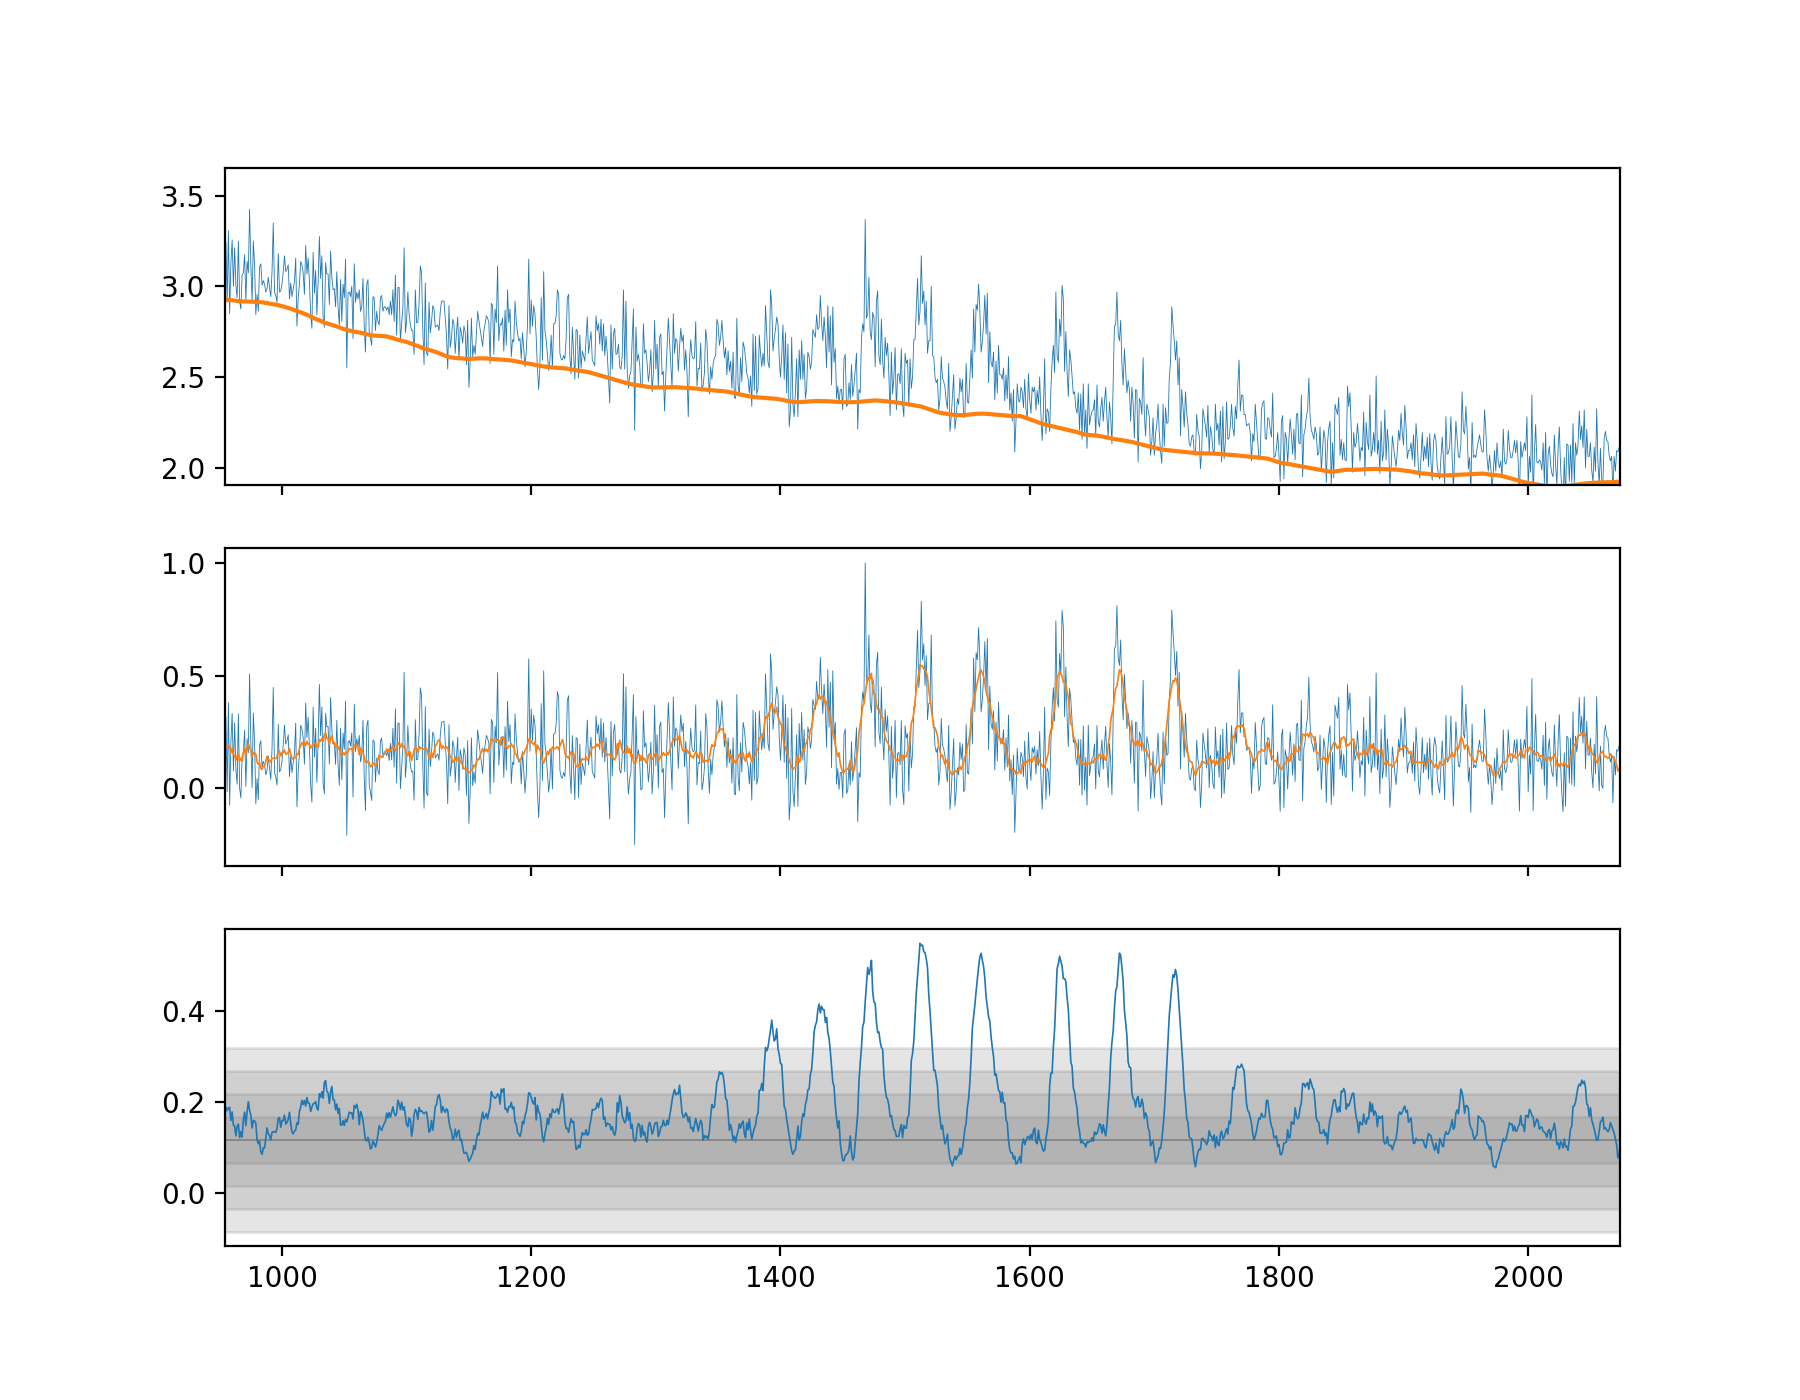

(0, 12800)

In [203]:
x = ts[0].copy()
fig, axs = plt.subplots(3,1,figsize=(9,7), sharex=True)
# wIron   = 1./100
# ironedx = signal.filtfilt(*signal.butter(2, wIron,   output='ba'), x=x)
# ironedx = signal.medfilt(x,[wBottom+1])
wIron = 51
ironedx = percFilter(x,perc=10,filterSize=wIron)
ironedx = runningAverage(ironedx,wIron)
axs[0].plot(x,lw=.3)
axs[0].plot(ironedx)
x = x-ironedx

axs[1].plot(x,lw=.3)

# wSlight = 1./5
# slightFilteredx = signal.filtfilt(*signal.butter(2, wSlight, output='ba'), x=x)
slightFilteredx = runningAverage(x,11)
axs[1].plot(slightFilteredx,"-",lw=.6,ms=1)

m,s = slightFilteredx.mean(), slightFilteredx.std()
axs[2].axhline(m,color="grey",lw=.6)
for ns in range(1,5):
    axs[2].fill_between(axs[2].get_xlim(),[m-ns*s]*2,[m+ns*s]*2, color="grey",alpha = .2)
    axs[2].text(0,m-ns*s,r"$ -%i\sigma$"%ns,va="center",fontsize=8)
    axs[2].text(0,m+ns*s,r"$ +%i\sigma$"%ns,va="center",fontsize=8)

axs[2].plot(slightFilteredx,"-",lw=.6,ms=1,)

# # axs[1].plot([])

# # subsampleDelta = int(1/wSlight)
# # axs[1].plot(rebin(np.arange(0,len(slightFilteredx)),subsampleDelta),
# #             rebin(slightFilteredx, subsampleDelta),
# #             lw=.4)


axs[0].set_xlim(0,len(x))
# axs[0].set_xlim(0,2000)
# fig.tight_layout()

In [229]:
def decay(time,top,bottom,rate):
#     top,bottom,rate = p
    return bottom+(top-bottom)*np.exp(-time*rate)
from scipy.optimize import curve_fit
def guessDecayPars(y):
    b0 = np.nanmin(y)
    y = np.log(y-b0)
    r0 = np.diff(y)
    r0 = -np.nanmean(r0[:len(r0)//2])
    t0 = np.nanpercentile(y,99)
    p0 = (np.exp(t0)+b0,b0,r0)
    return p0

In [230]:
def decayfit(x):
    p0 = guessDecayPars(x)
    ff = np.isfinite(x)
    tt = np.arange(len(x))
    popt = curve_fit(decay,tt[ff],x[ff],p0=p0)[0]
    expDecay = decay(tt,*popt)
    return expDecay

<IPython.core.display.Javascript object>


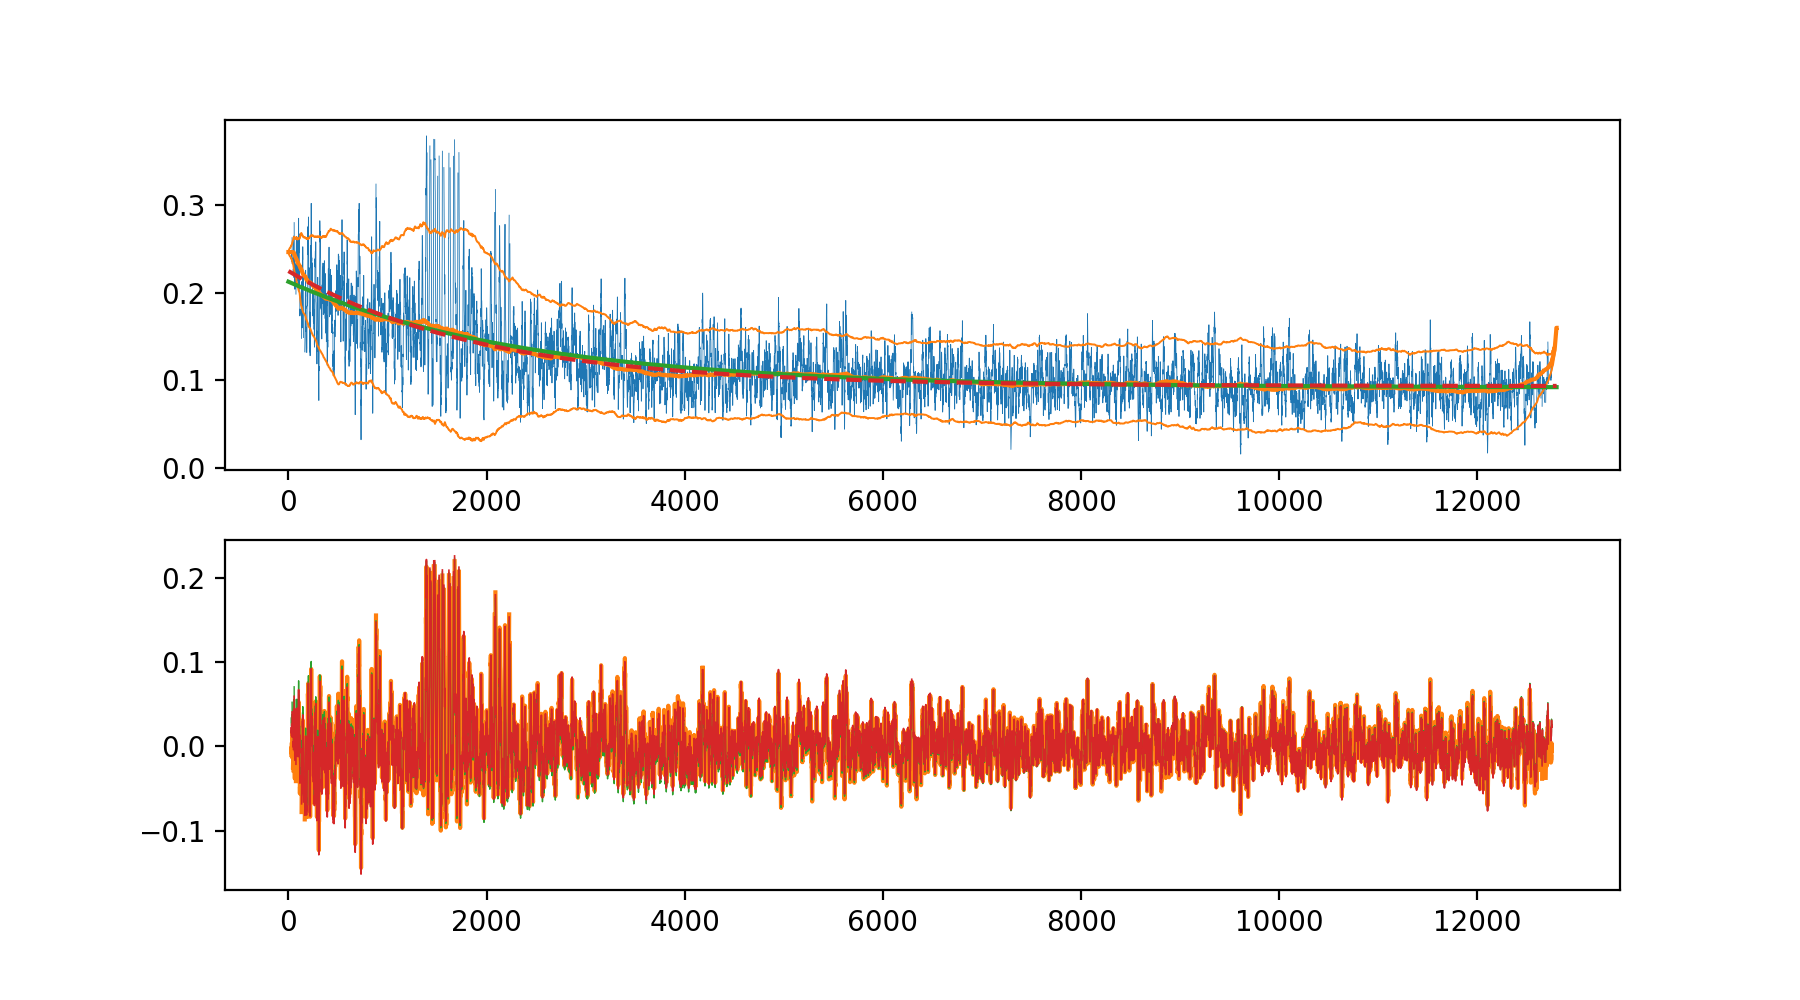

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [231]:
fig, axs = plt.subplots(2,1,figsize=(9,5))
x = slightFilteredx.copy()
md = percFilter(x,50,1000)
sd = percFilter(np.abs(x-md),50,1000)*1.48
x[x>md+4*sd] = np.nan
x[x<md-4*sd] = np.nan
axs[0].plot(x,lw=.3)
axs[1].plot([])
axs[0].plot(md)
axs[1].plot(x-md) #---------
axs[0].plot(md+2*sd,"C1", lw=.7)
axs[0].plot(md-2*sd,"C1", lw=.7)
axs[0].plot(decayfit(x))
axs[1].plot(x-decayfit(x),lw=.5) #---------
axs[0].plot(  decayfit(md),"--")
axs[1].plot(x-decayfit(md),lw=.6) #-----------
# x = ts[0].copy()

# p0 = guessDecayPars(x)

# plt.figure()
# plt.plot(x)
# plt.plot(decay(np.arange(len(x)),*p0))
# popt = curve_fit(decay,np.arange(len(x)),x,p0=p0)[0]
# expDecay = decay(np.arange(len(x)),*popt)
# plt.plot(expDecay)

There is still some exponential decay, but it should work

In [140]:
thresholdSigma = 3

In [158]:
%%time
detrendedAndFiltered = np.zeros_like(ts)
# for i in range(NRois):  ####################### this!
for i in range(10):
    x = ts[i].copy()
    ironedx = percFilter(x,10,wIron)
    x = x-ironedx
    x = signal.filtfilt(*signal.butter(2, wSlight, output='ba'), x=x)
    detrendedAndFiltered[i] = x

CPU times: user 17.5 s, sys: 70.4 ms, total: 17.6 s
Wall time: 17.6 s


In [161]:
%%time
thresholdSigma = 4
rasterImage = np.zeros_like(ts).astype(np.uint8)
for i in range(NRois):
    x = detrendedAndFiltered[i]
    m,s = x.mean(),x.std()
    rasterImage[i] = (x > m + thresholdSigma*s).astype(int)

CPU times: user 15.7 ms, sys: 3.62 ms, total: 19.3 ms
Wall time: 17.1 ms


<IPython.core.display.Javascript object>


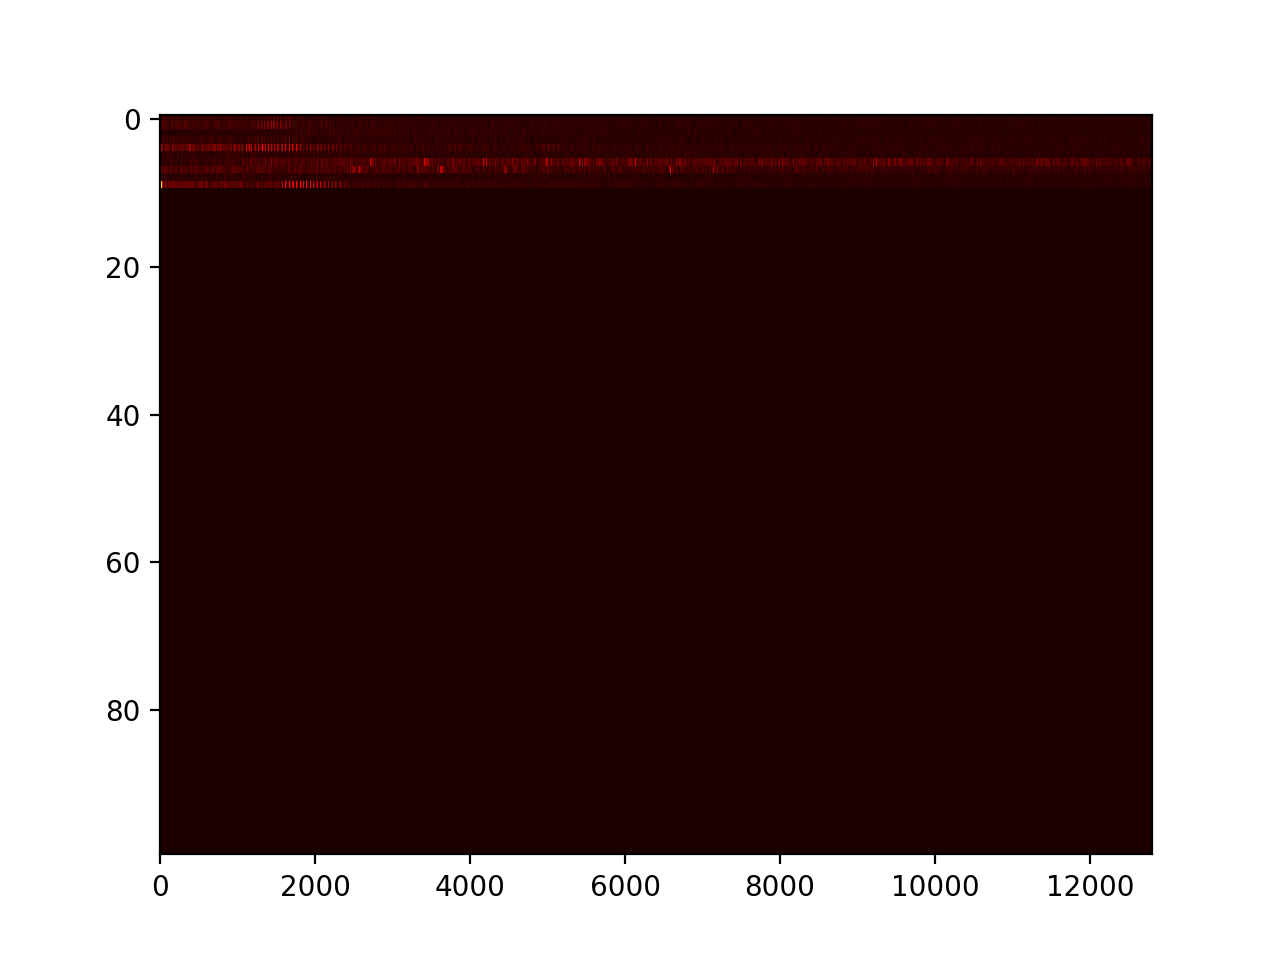

In [159]:
plt.figure()
plt.imshow(detrendedAndFiltered, cmap="hot")
plt.gca().set_aspect("auto")

<IPython.core.display.Javascript object>


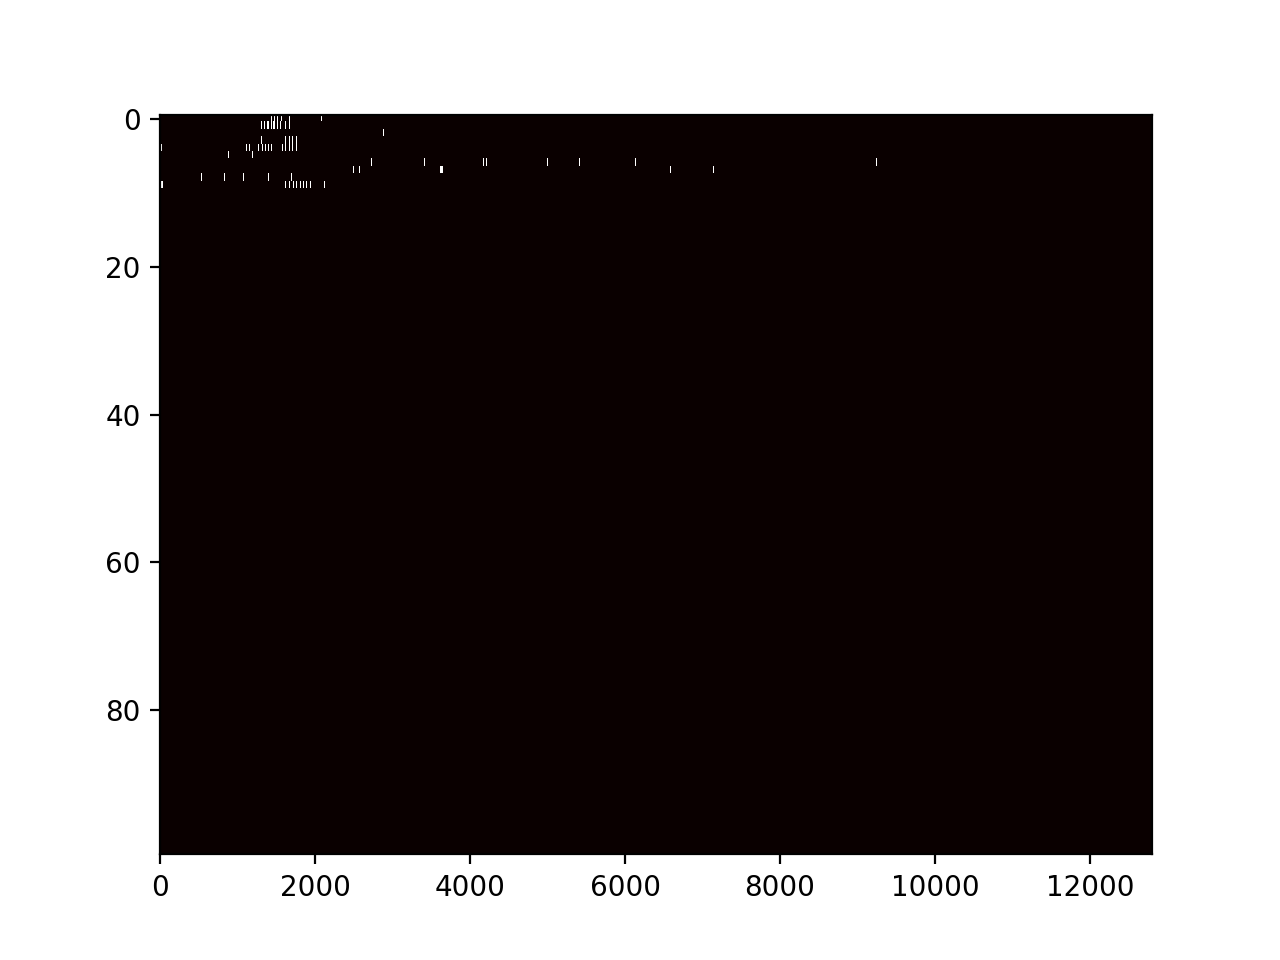

In [162]:
plt.figure()
plt.imshow(rasterImage, cmap="hot")
plt.gca().set_aspect("auto")